# Nuclie Semantic Segmentation - UNet using Tensorflow 2

# Intro
- Dataset used is from Kaggle's Data Science Bowl 2018 - Nuclei Segmentation
- The architecture used is [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this.
- This notebook is inspired from the great kernel [Keras U-net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) by Kjetil Åmdal-Sævik.

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile
from random import shuffle
import skimage.io
import cv2

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 96
IMG_HEIGHT = 96
IMG_CHANNELS = 3

exp_name = "unet_images_8v3"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Define paths
ROOT_DIR = os.path.abspath(".")
NPY_DIR = os.path.join(ROOT_DIR, "testappend/")
TEST_PATH = os.path.join(ROOT_DIR, "testappend", "images/")
LOGS_PATH = os.path.join(ROOT_DIR, "logs")
print(TEST_PATH)

/Users/johnshieh/Lab2020/unet/testappend/images/


In [2]:
x_train = np.load(os.path.join(NPY_DIR, "images_8.npy"))
y_train = np.load(os.path.join(NPY_DIR, "masks_8.npy"))
nb_cases = x_train.shape[0]
ind_list = [i for i in range(nb_cases)]
shuffle(ind_list)
nb_valid = int(nb_cases*0.2)
x_valid, y_valid = x_train[ind_list[:nb_valid]], y_train[ind_list[:nb_valid]]
x_train, y_train = x_train[ind_list[nb_valid:]], y_train[ind_list[nb_valid:]]

In [3]:
print(x_train.shape, y_train.shape)

x_train = x_train/255.0
#y_train = y_train.astype(np.uint8)
print(x_train.max(), y_train.max())

(12, 96, 96, 3) (12, 96, 96, 4)
1.0 1.0


In [4]:
# # Get train and test IDs
# train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]
# final_test_ids = next(os.walk(FINAL_TEST_PATH))[1]

# Get the data
- Downsample both the training and test images to reduce computations
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings 

In [5]:
# # Get and resize train images and masks
# X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
# print('Getting and resizing train images and masks ... ')

In [6]:
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
#     #Read image files iteratively
#     path = TRAIN_PATH + id_
#     img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
#     #Append image to numpy array for train dataset
#     X_train[n] = img
    
#     #Read corresponding mask files iteratively
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
#     #Looping through masks
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
        
#         #Read individual masks
#         mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
#         #Expand individual mask dimensions
#         mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
        
#         #Overlay individual masks to create a final mask for corresponding image
#         mask = np.maximum(mask, mask_)
    
#     #Append mask to numpy array for train dataset
#     Y_train[n] = mask

# # Get and resize test images
# X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
# print('Getting and resizing test images ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path = TEST_PATH + id_
    
#     #Read images iteratively
#     img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
#     #Get test size
#     sizes_test.append([img.shape[0], img.shape[1]])
    
#     #Resize image to match training data
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
#     #Append image to numpy array for test dataset
#     X_test[n] = img

# print('Done!')

## Visualize imported data

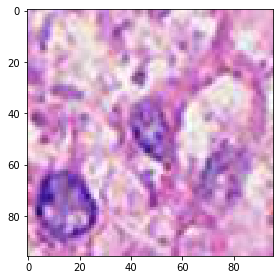

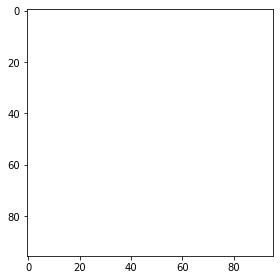

In [7]:
# Check if training data looks all right
#ix = random.randint(0, len(train_ids))

ix = 0
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()

In [8]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(4, (1, 1), activation='softmax') (c9)


In [9]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=4), 'accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 96, 96, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
# Fit model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('{}/{}.h5'.format(LOGS_PATH, exp_name), verbose=1, save_best_only=True)
results = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=1, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 12 samples, validate on 3 samples
Epoch 1/100
11/12 [==========================>...] - ETA: 0s - loss: 1.1785 - mean_io_u: 0.3750 - accuracy: 0.6111
Epoch 00001: val_loss improved from inf to 14.47648, saving model to /Users/johnshieh/Lab2020/unet/logs/unet_images_8v3.h5
12/12 [==============================] - 10s 793ms/sample - loss: 1.1360 - mean_io_u: 0.3750 - accuracy: 0.6326 - val_loss: 14.4765 - val_mean_io_u: 0.2979 - val_accuracy: 0.1012
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.6136 - mean_io_u: 0.3750 - accuracy: 0.9230
Epoch 00002: val_loss did not improve from 14.47648
12/12 [==============================] - 2s 192ms/sample - loss: 0.5954 - mean_io_u: 0.3750 - accuracy: 0.9270 - val_loss: 14.5216 - val_mean_io_u: 0.2956 - val_accuracy: 0.0989
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 0.4301 - mean_io_u: 0.3750 - accuracy: 0.9627
Epoch 00003: val_loss improved from 14.47648 to 14.31161, saving model to /Users

11/12 [==========================>...] - ETA: 0s - loss: 0.0180 - mean_io_u: 0.3750 - accuracy: 0.9974
Epoch 00022: val_loss did not improve from 2.03435
12/12 [==============================] - 3s 245ms/sample - loss: 0.0177 - mean_io_u: 0.3750 - accuracy: 0.9974 - val_loss: 2.1734 - val_mean_io_u: 0.8388 - val_accuracy: 0.8649
Epoch 23/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0201 - mean_io_u: 0.3750 - accuracy: 0.9966
Epoch 00023: val_loss did not improve from 2.03435
12/12 [==============================] - 3s 253ms/sample - loss: 0.0192 - mean_io_u: 0.3750 - accuracy: 0.9968 - val_loss: 2.1903 - val_mean_io_u: 0.8379 - val_accuracy: 0.8633
Epoch 24/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0189 - mean_io_u: 0.3750 - accuracy: 0.9971
Epoch 00024: val_loss did not improve from 2.03435
12/12 [==============================] - 3s 227ms/sample - loss: 0.0181 - mean_io_u: 0.3750 - accuracy: 0.9972 - val_loss: 2.0689 - val_mean_io_u: 0.8453 - va


# Make predictions

In [11]:
def visualize(name1, **images):
    """Plot images in one row."""
    
    norm=plt.Normalize(0,3) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue"])

    
    n = len(images)
    plt.figure(figsize=(18, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    
    #file = os.path.join(figresults_path, "{}.png".format(name1[:-4]))
    #print(figresults_path)
    #print("filename: " + file)
    #plt.savefig(file, bbox_inches="tight")
    plt.show()

In [12]:
model = None
model = load_model("{}/{}.h5".format(LOGS_PATH, exp_name))

In [ ]:
# model = None
# model = load_model('{}/{}.h5'.format(LOGS_PATH, exp_name), compile=False)
# model.summary()

Index: 6, Filename: 14.png
Image shape: (96, 96, 3) <class 'numpy.ndarray'>
[4.2882988e-05 4.3444848e-05 4.6672678e-05 ... 9.8682922e-01 9.8729950e-01
 9.8735064e-01]
[0 1]
[0 1]


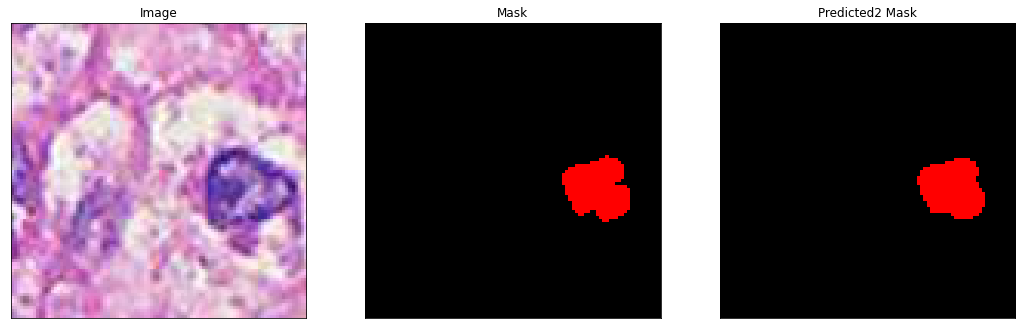

In [19]:
image_fns = sorted(next(os.walk(TEST_PATH))[2])
idx = random.randrange(len(image_fns))
print("Index: {}, Filename: {}".format(idx, image_fns[idx]))

image = skimage.io.imread(os.path.join(TEST_PATH, image_fns[idx]))
print("Image shape:", image.shape, type(image))
image = image/255.0

pred = np.expand_dims(image, axis=0)
pred = model.predict(pred)
print(np.unique(pred[:,:,:,1]))
pred = np.argmax(pred.squeeze(), axis=-1)

print(np.unique(pred))
pred = pred.astype(np.uint8)
print(np.unique(pred))

pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)

visualize(
        image_fns[idx],
        image=image,
        mask = pred,
        Predicted2_mask = pred_filt
    )

In [ ]:
# Predict on train, val and test
model = load_model('model_unet_checkpoint.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()